In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
from scipy.stats import shapiro
from scipy.stats import ttest_ind
import scipy.sparse
from scipy.stats import mannwhitneyu

import scanpy as sc

import re

import gseapy as gp
from gseapy import dotplot

from adjustText import adjust_text  

import warnings
import pickle

from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import anndata as ad
from tqdm import tqdm

In [2]:
adata=ad.read_h5ad('./Data/adata_for_stats')

In [3]:
adata_for_lmm=adata.copy()
adata_for_lmm.X=adata.layers['knn_imputed_from_log2_total_norm_ds']

In [4]:
df = pd.DataFrame({
    "protein_expression": adata_for_lmm.X.flatten(),
    "condition": np.repeat(adata_for_lmm.obs["condition"].values, adata_for_lmm.shape[1]),
    "passage": np.repeat(adata_for_lmm.obs["passage"].values, adata_for_lmm.shape[1]),
    "protein": np.tile(adata_for_lmm.var_names, adata_for_lmm.shape[0])  # Protein names
})

# Ensure categorical variables are properly set
df["condition"] = df["condition"].astype("category")
df["passage"] = df["passage"].astype(int)  # If passage is numeric

df

,protein_expression,condition,passage,protein
0,-1.545846,AN,9,SEPTIN7
1,-0.246468,AN,9,MISP3
2,-0.175221,AN,9,UBXN8
3,0.120008,AN,9,SRCIN1
4,-0.746624,AN,9,NSMCE2
...,...,...,...,...
1132637,-0.659875,A,8,MTHFD1-1
1132638,0.461594,A,8,TAP2-1
1132639,1.346169,A,8,SLC27A3
1132640,-1.672921,A,8,UBR4-1


In [5]:
# Define the list of proteins to keep
#selected_proteins = ["GCAT", "CAVIN1", "CTSC", "NME4"]

# Subset the dataframe to include only selected proteins
#df = df[df["protein"].isin(selected_proteins)]

In [6]:
df

,protein_expression,condition,passage,protein
0,-1.545846,AN,9,SEPTIN7
1,-0.246468,AN,9,MISP3
2,-0.175221,AN,9,UBXN8
3,0.120008,AN,9,SRCIN1
4,-0.746624,AN,9,NSMCE2
...,...,...,...,...
1132637,-0.659875,A,8,MTHFD1-1
1132638,0.461594,A,8,TAP2-1
1132639,1.346169,A,8,SLC27A3
1132640,-1.672921,A,8,UBR4-1


# Models

In [7]:
def safe_extract_random_effects(model_result, protein_name):
    """Safely extracts random effects without failing due to singular covariance structures."""
    try:
        return model_result.random_effects
    except (AttributeError,ValueError, np.linalg.LinAlgError) as e:
        print(f"⚠️ Warning: Failed to extract random effects for {protein_name} due to singular covariance structure: {e}")
        return np.nan  # Return NaN instead of failing


def extract_model_results(model_results, protein_names):
    all_results = {}
    all_p_values = []
    p_value_indices = []

    for protein, model_result in zip(protein_names, model_results):
        extracted = {}

        attributes = {
            "params": "coefficients",
            "pvalues": "p-values",
            "bse": "std_errors",
            "aic": "AIC",
            "bic": "BIC",
            "llf": "log_likelihood",
            "df_model": "df_model",
            "df_resid": "df_residual",
            "scale": "residual_variance",
            "rsquared": "r_squared",
            "rsquared_adj": "adjusted_r_squared",
            "cov_params": "covariance_matrix",
            "fe_params": "fixed_effects",
            "cov_re": "random_effects_covariance",
            "cov_fe": "fixed_effects_covariance",
            "scale_re": "random_effects_variance",
            "converged": "convergence_status",
        }

        for attr, name in attributes.items():
            if hasattr(model_result, attr):
                extracted[name] = getattr(model_result, attr)

        # Ensure safe extraction of random effects, now with the protein name
        extracted["random_effects"] = safe_extract_random_effects(model_result, protein)

        # ⚠️ Prevent accessing `fittedvalues` if `random_effects` failed
        if extracted["random_effects"] is not np.nan:
            try:
                extracted["fitted_values"] = model_result.fittedvalues
                extracted["residuals"] = model_result.resid
            except (ValueError, np.linalg.LinAlgError):
                print(f"⚠️ Warning: Skipping fitted values & residuals for {protein} due to singular matrix.")
                extracted["fitted_values"] = np.nan
                extracted["residuals"] = np.nan
       
        # Extract convergence status
        extracted["convergence_status"] = getattr(model_result, "converged", None)
        
        # Convert extracted parameters into DataFrames where applicable
        if isinstance(extracted.get("coefficients"), pd.Series):
            extracted["coefficients"] = extracted["coefficients"].to_frame(name="estimate")
        
        if isinstance(extracted.get("p-values"), pd.Series):
            extracted["p-values"] = extracted["p-values"].to_frame(name="p_value")
            
            # Store p-values for later FDR correction
            non_nan_pvals = extracted["p-values"].dropna()["p_value"]
            all_p_values.extend(non_nan_pvals.tolist())
            p_value_indices.extend([(protein, idx) for idx in non_nan_pvals.index])
        
        if isinstance(extracted.get("std_errors"), pd.Series):
            extracted["std_errors"] = extracted["std_errors"].to_frame(name="std_error")
        
        # Extract interaction effects separately
        if "coefficients" in extracted:
            interaction_mask = extracted["coefficients"].index.str.contains(":")
            if interaction_mask.any():
                extracted["interaction_effects"] = extracted["coefficients"].loc[interaction_mask]
                extracted["interaction_effects"]["p_value"] = extracted["p-values"].loc[interaction_mask, "p_value"]
                extracted["interaction_effects"]["std_error"] = extracted["std_errors"].loc[interaction_mask, "std_error"]
        
        all_results[protein] = extracted
    
    # Apply FDR correction across all collected p-values
    if all_p_values:
        fdr_corrected_pvals = multipletests(all_p_values, method='fdr_bh')[1]
        
        # Assign back corrected p-values
        for (protein, idx), fdr_pval in zip(p_value_indices, fdr_corrected_pvals):
            all_results[protein]["p-values"].loc[idx, "p_value_fdr"] = fdr_pval
    
    return all_results


In [8]:
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

# Initialize lists to store results
results_list = []
random_intercepts = []
residuals_list = []

protein_names = df["protein"].unique()  # List of protein identifiers
model_results = []  # Store model fits
# Fit LME model for each protein with progress bar
for protein in tqdm(protein_names, desc="Fitting OLS models"):
    df_subset = df[df["protein"] == protein].copy()
    
    try:
        # Random intercept model
        result = smf.ols("protein_expression ~ condition", df_subset).fit()

      
    except Exception as e:
        print(f"Error fitting model for {protein}: {e}")
        result = None 


    model_results.append(result)  # Store the fitted model

# Convert results to DataFrames

# Use extract_model_results function to process results
ols1_extracted_results = extract_model_results(model_results, protein_names)

# Accessing results for a specific protein
#ols1_protein_x_results = ols1_extracted_results["GCAT"]  # Example access


Fitting OLS models: 100%|███████████████████████████████████████████████████████████| 9518/9518 [06:13<00:00, 25.50it/s]


⚠️ Warning: Failed to extract random effects for SEPTIN7 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for MISP3 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for UBXN8 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for SRCIN1 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for NSMCE2 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for PSMB3 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for UHRF1 due to singular covariance structure: 'OLSResults' object h

In [9]:
ols1_extracted_results = extract_model_results(model_results, protein_names)

⚠️ Warning: Failed to extract random effects for SEPTIN7 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for MISP3 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for UBXN8 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for SRCIN1 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for NSMCE2 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for PSMB3 due to singular covariance structure: 'OLSResults' object has no attribute 'random_effects'
⚠️ Warning: Failed to extract random effects for UHRF1 due to singular covariance structure: 'OLSResults' object h

In [10]:
# Define the filename
filename = "./Data/ols1_extracted_results_03032025.pkl"

# Save the object
with open(filename, "wb") as f:
    pickle.dump(ols1_extracted_results, f)

In [ ]:
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

# Initialize lists to store results
results_list = []
random_intercepts = []
residuals_list = []

protein_names = df["protein"].unique()  # List of protein identifiers
model_results = []  # Store model fits
# Fit LME model for each protein with progress bar
for protein in tqdm(protein_names, desc="Fitting OLS models"):
    df_subset = df[df["protein"] == protein].copy()
    
    try:
        # Random intercept modela
        result = smf.ols("protein_expression ~ condition + passage", df_subset).fit()

      
    except Exception as e:
        print(f"Error fitting model for {protein}: {e}")
        result = None 


    model_results.append(result)  # Store the fitted model

# Convert results to DataFrames

# Use extract_model_results function to process results
ols2_extracted_results = extract_model_results(model_results, protein_names)

# Accessing results for a specific protein
#ols1_protein_x_results = ols1_extracted_results["GCAT"]  # Example access


Fitting OLS models:   2%|█▏                                                          | 183/9501 [00:07<06:17, 24.70it/s]

In [ ]:
# Define the filename
filename = "./Data/ols2_extracted_results_03032025.pkl"

# Save the object
with open(filename, "wb") as f:
    pickle.dump(ols2_extracted_results, f)

In [ ]:
ols2_extracted_results

In [ ]:
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

# Initialize lists to store results
results_list = []
random_intercepts = []
residuals_list = []

protein_names = df["protein"].unique()  # List of protein identifiers
model_results = []  # Store model fits
# Fit LME model for each protein with progress bar
for protein in tqdm(protein_names, desc="Fitting OLS models"):
    df_subset = df[df["protein"] == protein].copy()
    
    try:
        # Random intercept modela
        result = smf.ols("protein_expression ~ condition*passage", df_subset).fit()

      
    except Exception as e:
        print(f"Error fitting model for {protein}: {e}")
        result = None 


    model_results.append(result)  # Store the fitted model

# Convert results to DataFrames

# Use extract_model_results function to process results
ols3_extracted_results = extract_model_results(model_results, protein_names)

# Accessing results for a specific protein
#ols1_protein_x_results = ols1_extracted_results["GCAT"]  # Example access


In [ ]:
# Define the filename
filename = "./Data/ols3_extracted_results_03032025.pkl"

# Save the object
with open(filename, "wb") as f:
    pickle.dump(ols3_extracted_results, f)

In [ ]:
ols3_extracted_results

In [ ]:
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

# Initialize lists to store results
results_list = []
random_intercepts = []
residuals_list = []

protein_names = df["protein"].unique()  # List of protein identifiers
model_results = []  # Store model fits
# Fit LME model for each protein with progress bar
for protein in tqdm(protein_names, desc="Fitting LME models"):
    df_subset = df[df["protein"] == protein].copy()
    
    try:
        # Random intercept model
        model = smf.mixedlm("protein_expression ~ 1", df_subset, groups=df_subset["passage"])
        result = model.fit(reml=False)

      
    except Exception as e:
        print(f"Error fitting model for {protein}: {e}")
        result = None 


    model_results.append(result)  # Store the fitted model

# Convert results to DataFrames

# Use extract_model_results function to process results
lme1_extracted_results = extract_model_results(model_results, protein_names)

# Accessing results for a specific protein
#lme1_protein_x_results = lme1_extracted_results["GCAT"]  # Example access


In [ ]:
# Define the filename
filename = "./Data/lme1_extracted_results_03032025.pkl"

# Save the object
with open(filename, "wb") as f:
    pickle.dump(lme1_extracted_results, f)

In [ ]:
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

# Initialize lists to store results
results_list = []
random_intercepts = []
residuals_list = []

protein_names = df["protein"].unique()  # List of protein identifiers
model_results = []  # Store model fits
# Fit LME model for each protein with progress bar
for protein in tqdm(protein_names, desc="Fitting LME models"):
    df_subset = df[df["protein"] == protein].copy()
    
    try:
        # Random intercept model
        model = smf.mixedlm("protein_expression ~ 1", df_subset, groups=df_subset["passage"],re_formula="1+passage")
        result = model.fit(reml=False)

      
    except Exception as e:
        print(f"Error fitting model for {protein}: {e}")
        result = None 


    model_results.append(result)  # Store the fitted model

# Convert results to DataFrames

# Use extract_model_results function to process results
lme2_extracted_results = extract_model_results(model_results, protein_names)

# Accessing results for a specific protein
#lme1_protein_x_results = lme1_extracted_results["GCAT"]  # Example access


In [ ]:
# Define the filename
filename = "./Data/lme2_extracted_results_03032025.pkl"

# Save the object
with open(filename, "wb") as f:
    pickle.dump(lme2_extracted_results, f)

In [18]:
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

# Initialize lists to store results
results_list = []
random_intercepts = []
residuals_list = []

protein_names = df["protein"].unique()  # List of protein identifiers
model_results = []  # Store model fits
# Fit LME model for each protein with progress bar
for protein in tqdm(protein_names, desc="Fitting LME models"):
    df_subset = df[df["protein"] == protein].copy()
    
    try:
        # Random intercept model
        model = smf.mixedlm("protein_expression ~ condition", df_subset, groups=df_subset["passage"])
        result = model.fit(reml=False)

      
    except Exception as e:
        print(f"Error fitting model for {protein}: {e}")
        result = None 


    model_results.append(result)  # Store the fitted model

# Convert results to DataFrames

# Use extract_model_results function to process results
lme3_extracted_results = extract_model_results(model_results, protein_names)

# Accessing results for a specific protein
#lme1_protein_x_results = lme1_extracted_results["GCAT"]  # Example access


Fitting LME models: 100%|███████████████████████████████████████████████████████████| 9501/9501 [08:59<00:00, 17.61it/s]


⚠️ Warning: Failed to extract random effects for MAFK due to singular covariance structure: Cannot predict random effects from singular covariance structure.
⚠️ Warning: Failed to extract random effects for FHIP1B due to singular covariance structure: Cannot predict random effects from singular covariance structure.
⚠️ Warning: Failed to extract random effects for PHF12 due to singular covariance structure: Cannot predict random effects from singular covariance structure.


In [19]:
for model_result in model_results:
    if hasattr(model_result, "cov_re"):
        rank = np.linalg.matrix_rank(model_result.cov_re)
        dim = model_result.cov_re.shape[0]
        if rank < dim:
            print(f"⚠️ Warning: Singular covariance matrix detected for model. Rank: {rank}, Expected: {dim}")

KeyboardInterrupt: 

In [35]:
lme3_extracted_results = extract_model_results(model_results, protein_names)

⚠️ Warning: Failed to extract random effects for MAFK due to singular covariance structure: Cannot predict random effects from singular covariance structure.
⚠️ Warning: Failed to extract random effects for FHIP1B due to singular covariance structure: Cannot predict random effects from singular covariance structure.
⚠️ Warning: Failed to extract random effects for PHF12 due to singular covariance structure: Cannot predict random effects from singular covariance structure.


In [37]:
len(model_results)

9501

In [20]:
# Define the filename
filename = "./Data/lme3_extracted_results_03032025.pkl"

# Save the object
with open(filename, "wb") as f:
    pickle.dump(lme3_extracted_results, f)

In [21]:
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

# Initialize lists to store results
results_list = []
random_intercepts = []
residuals_list = []

protein_names = df["protein"].unique()  # List of protein identifiers
model_results = []  # Store model fits
# Fit LME model for each protein with progress bar
for protein in tqdm(protein_names, desc="Fitting LME models"):
    df_subset = df[df["protein"] == protein].copy()
    
    try:
        # Random intercept model
        model = smf.mixedlm("protein_expression ~ condition", df_subset, groups=df_subset["passage"],re_formula="1+passage")
        result = model.fit(reml=False)

      
    except Exception as e:
        print(f"Error fitting model for {protein}: {e}")
        result = None 


    model_results.append(result)  # Store the fitted model

# Convert results to DataFrames

# Use extract_model_results function to process results
lme4_extracted_results = extract_model_results(model_results, protein_names)

# Accessing results for a specific protein
#lme1_protein_x_results = lme1_extracted_results["GCAT"]  # Example access

Fitting LME models: 100%|███████████████████████████████████████████████████████████| 9501/9501 [22:34<00:00,  7.01it/s]


In [23]:
# Define the filename
filename = "./Data/lme4_extracted_results_03032025.pkl"

# Save the object
with open(filename, "wb") as f:
    pickle.dump(lme4_extracted_results, f)

In [10]:
with open("./Data/ols1_extracted_results_03032025.pkl", "rb") as f:
    ols1_extracted_results = pickle.load(f)
print('loaded')    
with open("./Data/ols2_extracted_results_03032025.pkl", "rb") as f:
    ols2_extracted_results = pickle.load(f)
print('loaded')  
with open("./Data/ols3_extracted_results_03032025.pkl", "rb") as f:
    ols3_extracted_results = pickle.load(f)
print('loaded')  
with open("./Data/lme1_extracted_results_03032025.pkl", "rb") as f:
    lme1_extracted_results = pickle.load(f)
print('loaded')
with open("./Data/lme2_extracted_results_03032025.pkl", "rb") as f:
    lme2_extracted_results = pickle.load(f)
print('loaded')
with open("./Data/lme3_extracted_results_03032025.pkl", "rb") as f:
    lme3_extracted_results = pickle.load(f)
print('loaded')
with open("./Data/lme4_extracted_results_03032025.pkl", "rb") as f:
    lme4_extracted_results = pickle.load(f)
print('loaded')


loaded
loaded
loaded
loaded
loaded
loaded
loaded


In [17]:
results=[
    ols1_extracted_results,ols2_extracted_results,ols3_extracted_results,
         lme1_extracted_results,lme2_extracted_results,
    lme3_extracted_results,
    lme4_extracted_results
        ]

In [8]:
#with open("lme3_extracted_results_03032025.pkl", "rb") as f:
#    lme3_extracted_results = pickle.load(f)


# Plotting

In [18]:
def plot_random_intercepts(all_results, by="passage", mode="individual"):
    """
    Plots random intercepts (stored as 'Group') over passage in either individual or average mode.
    """
    intercepts = []
    for protein, results in all_results.items():
        if results['convergence_status'] == True:
            if "random_effects" in results:
                intercept_values = {idx: val["Group"] for idx, val in results["random_effects"].items() if "Group" in val}
                if intercept_values:
                    intercepts.append(pd.Series(intercept_values, name=protein))
        
    if not intercepts:
        print("No random intercepts found.")
        return
    
    intercepts_df = pd.concat(intercepts, axis=1)

    if mode == "individual":
        intercepts_df.plot(marker='o', linestyle='-', legend=False)
    elif mode == "average":
        intercepts_df.T.boxplot()
        
    plt.gcf()
    plt.grid(False)
    plt.title("Random Intercepts")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(by.capitalize(),fontsize=20)
    plt.ylabel("Random Intercepts",fontsize=20)
    plt.show()


def plot_random_slopes(all_results, by="passage", mode="individual"):
    """
    Plots random slopes (stored as 'passage') over passage in either individual or average mode.
    """
    slopes = []
    for protein, results in all_results.items():
         if results['convergence_status'] == True:
            if "random_effects" in results:
                slope_values = {idx: val["passage"] for idx, val in results["random_effects"].items() if "passage" in val}
                if slope_values:
                    slopes.append(pd.Series(slope_values, name=protein))
        
    if not slopes:
        print("No random slopes found.")
        return
    
    slopes_df = pd.concat(slopes, axis=1)

    
    if mode == "individual":
        slopes_df.plot(marker='o', linestyle='-', legend=False)
    elif mode == "average":
        slopes_df.T.boxplot()
    
    plt.gcf()
    plt.grid(False)
    plt.title("Random Slopes")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(by.capitalize(),fontsize=20)
    plt.ylabel("Random Slopes",fontsize=20)
    plt.show()

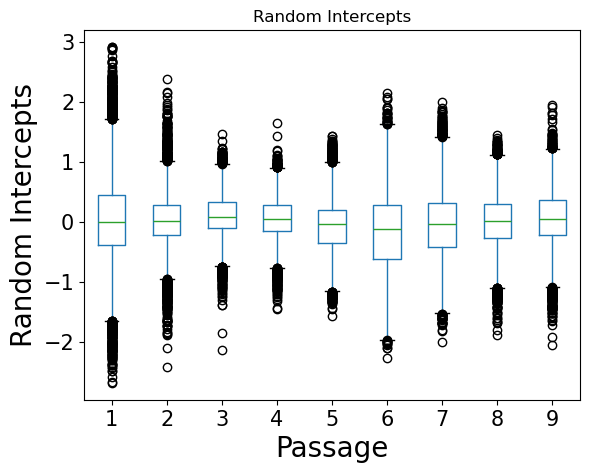

In [19]:
plot_random_intercepts(lme1_extracted_results, mode="average")

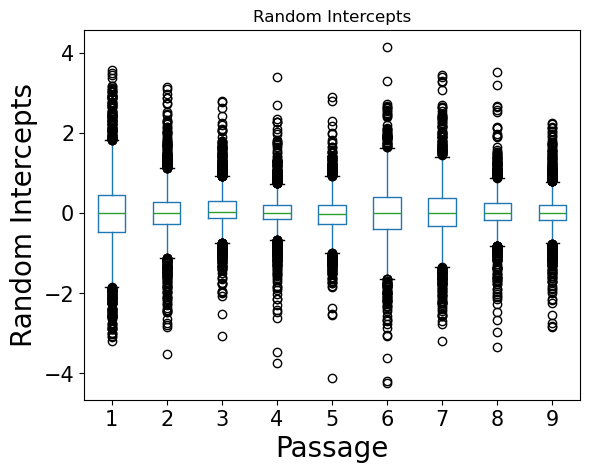

In [20]:
plot_random_intercepts(lme2_extracted_results, mode="average")

In [9]:
import pandas as pd
import numpy as np

# Function to extract only numeric values
def extract_number(value):
    if isinstance(value, (float, int)):  # If already a number, return as is
        return value
    if isinstance(value, str):  # If it's a string, extract numbers
        numbers = [float(num) for num in value.split() if num.replace('.', '', 1).replace('-', '', 1).isdigit()]
        return numbers[0] if numbers else np.nan
    if isinstance(value, pd.Series):  # If it's a Series, extract its first numeric value
        return extract_number(value.iloc[0])
    return np.nan  # Return NaN if nothing matches


In [43]:
def plot_random_intercepts(all_results, by="passage", mode="individual"):
    """
    Plots random intercepts over passage in either individual or average mode.
    """
    intercepts = []
    
    for protein, results in all_results.items():
        if results['convergence_status'] == True:

            random_effects = results.get("random_effects", {})
            try:
                random_effects.items()
            except:
                continue
            # Ensure it's a dictionary
            if not isinstance(random_effects, dict):
                print(f"Skipping {protein}: Expected dict in 'random_effects', got {type(random_effects)}")
                continue
            
            # Directly extract values, assuming they are floats
            intercept_values = {idx: val for idx, val in random_effects.items()} 
            
            if intercept_values:
                intercepts.append(pd.Series(intercept_values, name=protein))
        
    if not intercepts:
        print("No random intercepts found.")
        return
    
    intercepts_df = pd.concat(intercepts, axis=1)
    # Apply extraction function to all elements
    intercepts_df = intercepts_df.applymap(extract_number)
    
    # Convert entire DataFrame to float64
    intercepts_df = intercepts_df.astype(float)
    


    if intercepts_df.empty:
        print("No numerical data available for boxplot.")
        return

    if mode == "individual":
        intercepts_df.plot(marker='o', linestyle='-', legend=False)
    elif mode == "average":
        data = intercepts_df.T
        colors = cm.viridis(np.linspace(0, 1, data.shape[1]))

        fig, ax = plt.subplots(figsize=(8, 6))
        box = ax.boxplot([data[col] for col in data.columns],
                         patch_artist=True)

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor("black")

        for element in ['whiskers', 'caps', 'medians', 'fliers']:
            for line in box[element]:
                line.set_color("black")

        ax.set_xticks(np.arange(1, len(data.columns) + 1))
        ax.set_xticklabels(data.columns, fontsize=15)

    plt.gcf()
    plt.grid(False)
    plt.title("Random Intercepts")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(by.capitalize(),fontsize=20)
    plt.ylabel("Random Intercepts",fontsize=20)
    plt.show()
    return intercepts_df

/tmp/ipykernel_672/748363314.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  intercepts_df = intercepts_df.applymap(extract_number)


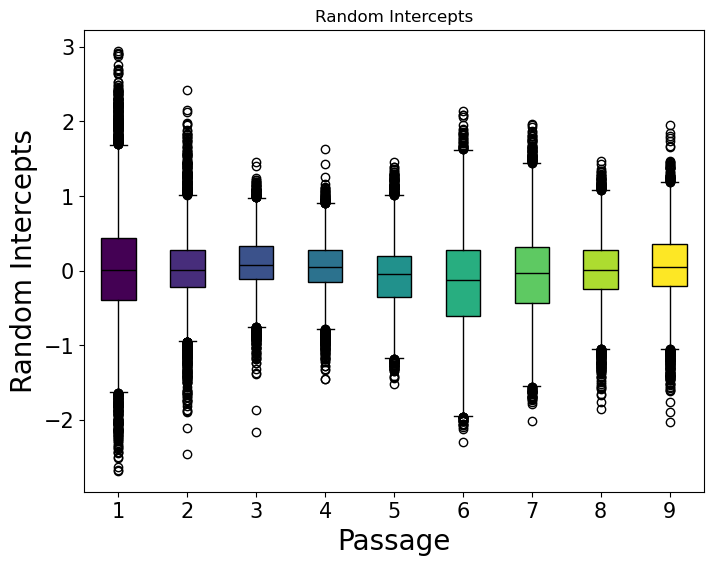

In [45]:
lme3_intercepts=plot_random_intercepts(lme3_extracted_results, mode="average")

In [ ]:
lme3_intercepts

/tmp/ipykernel_1950/2394683512.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  intercepts_df = intercepts_df.applymap(extract_number)


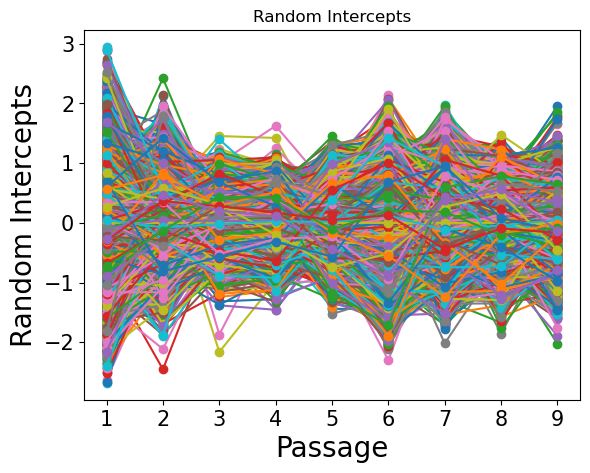

,SEPTIN7,MISP3,UBXN8,PSMB3,UHRF1,PSMB2,MPC1,LRMDA,TAP2,RAVER1,...,TCEA3-1,CAPNS1-1,CNN2-1,TPI1-1,U2SURP-1,UBA2-1,WDR18,DUSP12-1,TAP2-1,MINDY3-1
1,-0.079284,-0.153726,0.111198,-0.327793,0.515632,-0.042144,-0.710725,1.349958,1.050113,-0.668494,...,-0.226284,0.340090,-0.054949,0.272527,0.044408,0.691080,0.559786,-0.719635,-0.288294,-0.262363
2,-0.228414,-1.049910,-0.345995,-0.414425,-0.950954,-0.168134,-0.903203,-0.116889,-0.124203,0.581377,...,-0.292073,0.353402,-0.389342,0.579088,-0.075588,-0.813233,0.800214,-0.130501,0.363495,0.468142
3,0.210078,-0.603754,0.437585,0.172248,0.773764,-0.131402,-0.356151,0.110625,0.286771,0.535376,...,0.296361,-0.521173,0.155657,0.312801,-0.021680,-0.568478,0.289639,0.441272,0.278048,0.203560
4,0.228025,-0.462716,0.552406,0.406329,0.546617,0.094972,-0.493183,-0.422678,-0.438240,0.232529,...,0.182693,-0.270039,0.649478,-0.198613,0.025391,-0.317097,0.517854,0.414963,0.171449,0.110799
5,-0.616766,0.253117,-0.861815,0.142988,-0.890349,-0.373401,0.278584,-0.274041,-0.186476,0.639885,...,-0.367407,-0.225304,-0.636618,-0.746081,0.015441,-0.565657,-0.170809,-0.107610,0.046756,-0.442127
6,0.445181,1.241335,-1.490130,-0.073185,-1.662346,-0.310648,0.844186,-0.600846,0.579570,0.352168,...,0.623271,-0.935716,-1.159420,-0.515550,0.124164,0.680224,-0.550897,0.201941,0.127450,-0.886867
7,-0.211297,1.046380,0.312776,-0.058754,0.772178,0.411313,0.962825,0.777393,-0.458108,-0.947822,...,-0.378874,0.789508,0.259170,0.268071,-0.120642,0.951636,-1.242520,0.185297,-0.438939,0.381129
8,-0.026511,-0.018181,0.824747,0.047224,0.404516,0.282901,0.403703,-0.327680,-0.359347,-0.402429,...,-0.027493,0.490589,0.650627,0.487304,-0.043638,0.077625,-0.188231,-0.205918,-0.094540,0.559633
9,0.278988,-0.252545,0.459228,0.105368,0.490941,0.236543,-0.026036,-0.495841,-0.350080,-0.322591,...,0.189807,-0.021358,0.525397,-0.459547,0.052144,-0.136101,-0.015035,-0.079809,-0.165426,-0.131905


In [35]:
plot_random_intercepts(lme3_extracted_results, mode="individual")

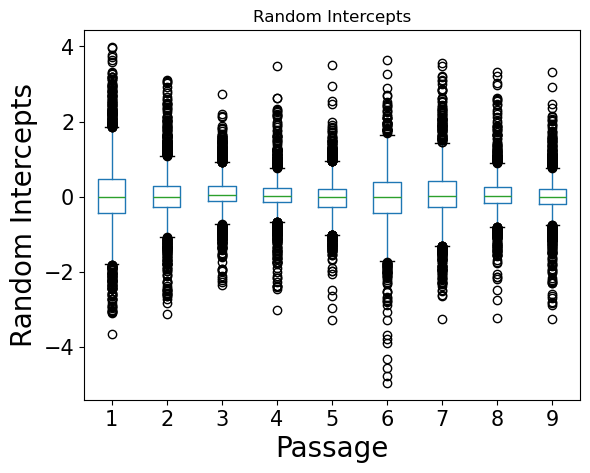

In [21]:
plot_random_intercepts(lme4_extracted_results, mode="average")

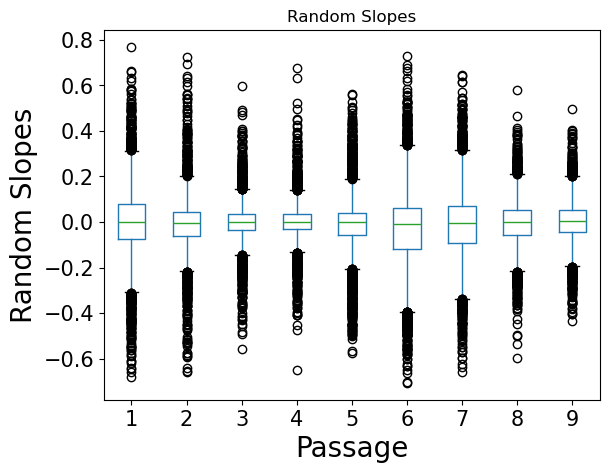

In [22]:
plot_random_slopes(lme2_extracted_results,mode="average")

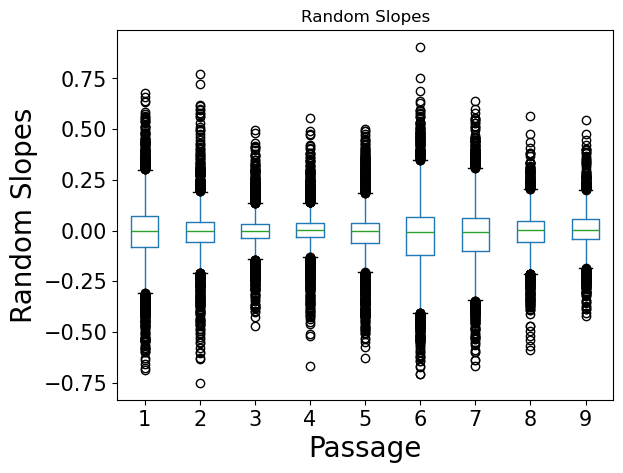

In [23]:
plot_random_slopes(lme4_extracted_results,mode="average")

In [24]:
def plot_fixed_effects(all_results, mode="average", specific_proteins=None, significance_threshold=0.1):
    """
    Plots fixed effects (intercept and condition-based slopes) across all proteins.
    Supports individual protein plots, an aggregated boxplot, and specific protein selection.
    Adds FDR significance stars only in individual mode.
    """
    effects = []
    p_values_fdr = []
    palette = {"A": "lightcoral", "N": "cornflowerblue", "AN": "sandybrown", "NA": "cadetblue"}
    for protein, results in all_results.items():
        #if specific_proteins and protein not in specific_proteins:
            #continue  # Skip proteins not in the specified list
        if results['convergence_status'] == True:

            if "fixed_effects" in results and "p-values" in results:
                fixed_effects = results["fixed_effects"]
                p_values = results["p-values"]

                for condition, effect in fixed_effects.items():
                    if condition == "Intercept":
                        condition_label = "A"  # Assuming Intercept corresponds to A
                    else:
                        condition_label = condition.replace("condition[T.", "").replace("]", "")
                    
                    # Extract FDR p-value correctly
                    # Extract FDR p-value safely
                    if condition in p_values.index and "p_value_fdr" in p_values.columns:
                        p_val_fdr = p_values.at[condition, "p_value_fdr"]  # Use .at for faster scalar lookup
                    else:
                        print(f"Warning: Missing p_value_fdr for condition: {condition} in protein: {protein}")
                        p_val_fdr = np.nan  # Assign NaN if missing
                    effects.append([protein, condition_label, effect, p_val_fdr])
   
 
    df = pd.DataFrame(effects, columns=["Protein", "Condition", "Effect", "p_value_fdr"])

    if df.empty:
        print("No OLS effects found.")
        return

    # Step 1: Keep only proteins present across all conditions
    proteins_by_condition_count = df.groupby("Protein")["Condition"].nunique()
    total_conditions = df["Condition"].nunique()
    complete_proteins = proteins_by_condition_count[proteins_by_condition_count == total_conditions].index

    df = df[df["Protein"].isin(complete_proteins)]

    # Step 2: Compute minimum p-value per protein and keep top 10
    top10_proteins = (
        df.groupby("Protein")["p_value_fdr"]
        .min()
        .nsmallest(10)
        .index
    )

    #df = df[df["Protein"].isin(top10_proteins)]

    if mode == "individual" or mode == "specific":
        significant_df = df[df["p_value_fdr"] < significance_threshold]

        if significant_df.empty:
            print(f"No significant proteins found below threshold: {significance_threshold}.")
            return

        plt.figure(figsize=(8, 6))

        for protein, group in significant_df.groupby("Protein"):
            plt.plot(group["Condition"], group["Effect"], marker='o', linestyle='-', label=protein)

        # Add significance stars
        for _, row in significant_df.iterrows():
            p_val = row["p_value_fdr"]
            label = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            plt.text(row["Condition"], row["Effect"], label, ha='center', fontsize=10, fontweight='bold')

        plt.legend(title="Protein", bbox_to_anchor=(1.05, 1), loc='upper left')

    elif mode == "average":
       # df.boxplot(by="Condition", column="Effect")
        custom_palette = {
            "A": "lightcoral",   # pink/red
            "AN": "sandybrown",  # orange
            "N": "cornflowerblue",   # blue
            "NA": "cadetblue"   # teal
        }
        sns.boxplot(data=df, x="Condition", y="Effect",palette=custom_palette)


    plt.title("Fixed Effects (Intercepts and Slopes)")
    plt.grid(False)
    plt.xlabel("Condition",fontsize=20)
    plt.ylabel("Fixed Effects",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45)
    plt.show()

/tmp/ipykernel_38698/4164495082.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Condition", y="Effect",palette=custom_palette)


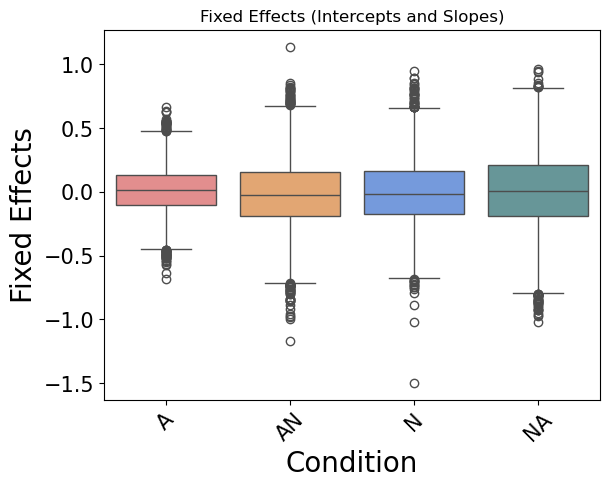

In [27]:
plot_fixed_effects(lme3_extracted_results, mode='average')

/tmp/ipykernel_38698/4164495082.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Condition", y="Effect",palette=custom_palette)


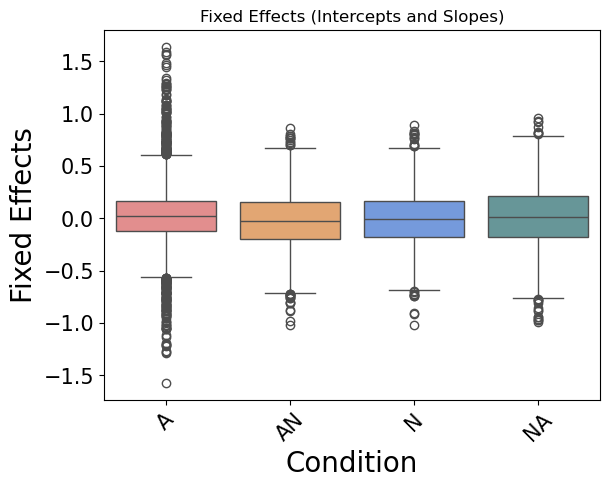

In [29]:
plot_fixed_effects(lme4_extracted_results, mode='average')

In [30]:
def format_results_table(all_results, attribute):
    """
    Convert extracted results into a clean table for display.
    """
    tables = []
    
    for protein, results in all_results.items():
        if attribute in results:
            df = results[attribute]
            if isinstance(df, dict):
                df = pd.DataFrame.from_dict(df, orient='index')
            if isinstance(df, pd.DataFrame):
                df = df.reset_index()
                df.insert(0, "Protein", protein)
                tables.append(df)
    
    if tables:
        final_table = pd.concat(tables, ignore_index=True)
        return final_table
    else:
        return pd.DataFrame()  # Return empty if attribute is missing


In [31]:
lem3_vals=format_results_table(lme3_extracted_results,'p-values')

In [32]:
sig_eff=set(lem3_vals[lem3_vals['p_value_fdr']<0.1]['Protein'].to_list())

In [33]:

from collections import Counter

def count_and_sort_elements(input_list):
    return dict(sorted(Counter(input_list).items(), key=lambda x: x[1], reverse=True))

# Example usage
input_list = (lem3_vals[lem3_vals['p_value_fdr']<0.1]['Protein'].to_list())
result = count_and_sort_elements(input_list)
print(result)


{'SDCBP-1': 3, 'GCAT': 3, 'HEXA': 3, 'VCP-3': 3, 'AKR1B10': 2, 'ADCY9': 2, 'TSPAN3': 2, 'KDM4A': 2, 'CRLF1': 2, 'SUPT3H': 2, 'CAVIN2': 2, 'AK1': 2, 'NR3C1': 2, 'HEXB-1': 2, 'CTSL': 2, 'KRT19-1': 2, 'ANXA3': 2, 'GNS': 2, 'UGT2B7': 2, 'SMPD1': 2, 'MAT2A': 2, 'CPT1A': 2, 'SSR4': 2, 'CTSC': 2, 'PSPH': 2, 'CDK16': 2, 'TP53BP1': 2, 'ILF3': 2, 'PDIA2': 2, 'SEMA3B': 2, 'DNAJC3': 2, 'STEAP3': 2, 'CAVIN1': 2, 'NOTUM': 2, 'SLCO4C1': 2, 'MTDH-2': 2, 'FAM241A': 2, 'ENAH-2': 2, 'PLA2G15': 2, 'FAM3C': 2, 'CMBL': 2, 'NEDD4L': 2, 'SEC11C': 2, 'EDEM3': 2, 'GPHN': 2, 'MTUS1': 2, 'FARP1-1': 2, 'HYOU1-1': 2, 'CPQ': 2, 'DDX3X': 1, 'PROS1': 1, 'MANBA': 1, 'KIF2A': 1, 'SLC3A2': 1, 'CANX-1': 1, 'MGA': 1, 'UBAP2L': 1, 'PTMS': 1, 'APOB': 1, 'MATR3': 1, 'IMMT': 1, 'MOGS': 1, 'PDIA4': 1, 'HEXB': 1, 'SEC31A': 1, 'PCBP2': 1, 'TIMM8B': 1, 'LONP1': 1, 'DNM2': 1, 'SUPT5H-1': 1, 'EXOC5': 1, 'NOP56': 1, 'NME4': 1, 'CES2': 1, 'UBFD1': 1, 'TPP1': 1, 'TAX1BP3': 1, 'CLGN': 1, 'NPC1': 1, 'PGRMC2': 1, 'RRP8': 1, 'HNRNPR': 1, '

In [34]:
print(result.keys())

dict_keys(['SDCBP-1', 'GCAT', 'HEXA', 'VCP-3', 'AKR1B10', 'ADCY9', 'TSPAN3', 'KDM4A', 'CRLF1', 'SUPT3H', 'CAVIN2', 'AK1', 'NR3C1', 'HEXB-1', 'CTSL', 'KRT19-1', 'ANXA3', 'GNS', 'UGT2B7', 'SMPD1', 'MAT2A', 'CPT1A', 'SSR4', 'CTSC', 'PSPH', 'CDK16', 'TP53BP1', 'ILF3', 'PDIA2', 'SEMA3B', 'DNAJC3', 'STEAP3', 'CAVIN1', 'NOTUM', 'SLCO4C1', 'MTDH-2', 'FAM241A', 'ENAH-2', 'PLA2G15', 'FAM3C', 'CMBL', 'NEDD4L', 'SEC11C', 'EDEM3', 'GPHN', 'MTUS1', 'FARP1-1', 'HYOU1-1', 'CPQ', 'DDX3X', 'PROS1', 'MANBA', 'KIF2A', 'SLC3A2', 'CANX-1', 'MGA', 'UBAP2L', 'PTMS', 'APOB', 'MATR3', 'IMMT', 'MOGS', 'PDIA4', 'HEXB', 'SEC31A', 'PCBP2', 'TIMM8B', 'LONP1', 'DNM2', 'SUPT5H-1', 'EXOC5', 'NOP56', 'NME4', 'CES2', 'UBFD1', 'TPP1', 'TAX1BP3', 'CLGN', 'NPC1', 'PGRMC2', 'RRP8', 'HNRNPR', 'TPD52L2-2', 'TGOLN2-2', 'MYO1B-2', 'RRP9', 'KDM1A', 'PPL', 'GMDS', 'PLOD3', 'DNAJC13', 'PHACTR2-1', 'SRSF10', 'NUP155', 'WDHD1', 'DGAT1', 'SOAT2', 'RSL1D1', 'MYO1D', 'UFL1', 'NDUFB4', 'NSA2', 'ACSL3', 'ASMTL', 'BAG2', 'AGR2', 'ALDH1A1',

In [35]:
sig_eff

{'AASS',
 'ABAT',
 'ABCB1',
 'ABHD4',
 'ABL2',
 'ACACA',
 'ACOT2',
 'ACOX1-1',
 'ACSL3',
 'ACTG2',
 'ACTR1A',
 'ADCY9',
 'ADIPOR1',
 'AGR2',
 'AGXT',
 'AIF1L',
 'AK1',
 'AKAP12',
 'AKR1B10',
 'ALCAM',
 'ALDH18A1',
 'ALDH1A1',
 'ALDH1L2',
 'ALDH4A1-1',
 'ALPL',
 'AMPD2',
 'ANKRD1',
 'ANPEP',
 'ANXA3',
 'ANXA4-1',
 'APOB',
 'APOBEC3C',
 'APOE',
 'ARHGAP29',
 'ARHGEF2',
 'ARL6IP4',
 'ASMTL',
 'ASRGL1',
 'ATAD2',
 'ATP6V0A1',
 'ATR',
 'BAG2',
 'BCCIP-1',
 'BOP1',
 'BRD2',
 'BRIX1',
 'BRWD1',
 'CACYBP',
 'CANX-1',
 'CAVIN1',
 'CAVIN2',
 'CDK16',
 'CES1',
 'CES2',
 'CHD6',
 'CHRAC1',
 'CHST3',
 'CISD1',
 'CKAP4',
 'CKB',
 'CLGN',
 'CLU',
 'CMBL',
 'COG6',
 'CORO2A',
 'COX19',
 'CPLX2',
 'CPQ',
 'CPT1A',
 'CPVL',
 'CRIP2',
 'CRLF1',
 'CTNNA1',
 'CTSC',
 'CTSD-1',
 'CTSH',
 'CTSL',
 'CWF19L2',
 'DAB2IP',
 'DCP1B',
 'DDX17-2',
 'DDX27',
 'DDX3X',
 'DDX47',
 'DDX52',
 'DDX54-1',
 'DDX56',
 'DGAT1',
 'DLG3',
 'DNAJC13',
 'DNAJC3',
 'DNM2',
 'DPP4',
 'DSG2',
 'ECT2',
 'EDEM3',
 'EEF1B2',
 'EIF2AK4

In [36]:
lem3_coefs=format_results_table(lme3_extracted_results, 'coefficients')

In [37]:
lem3_coefs

,Protein,index,estimate
0,SEPTIN7,Intercept,-0.140808
1,SEPTIN7,condition[T.AN],-0.011783
2,SEPTIN7,condition[T.N],0.140808
3,SEPTIN7,condition[T.NA],0.351743
4,SEPTIN7,Group Var,0.167162
...,...,...,...
47500,MINDY3-1,Intercept,0.214282
47501,MINDY3-1,condition[T.AN],0.011745
47502,MINDY3-1,condition[T.N],-0.564520
47503,MINDY3-1,condition[T.NA],-0.277397


In [39]:
import matplotlib.pyplot as plt

def plot_model_comparison(df_comparison):
    """
    Plots AIC and log-likelihood for different models, including standard deviations.
    AIC is plotted in the top subplot, while log-likelihood is in the bottom subplot.
    """
    plt.xticks(rotation=45, ha='right',fontsize=15)
    plt.yticks(fontsize=15)  # Ensure labels are readable
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0.1})  # Reduced space between plots


    metrics = df_comparison.set_index("Metric").T  # Transpose for plotting
    
    # Dictionary for renaming models
    model_name_map = {
        'C': 'Condition',
        'C_P': 'Condition + Passage',
        'CxP': 'Condition * Passage',
        'RI': '1|Passage',
        'RI_RS': '(1 + Condition)|Passage',
        'FC_RI': 'Condition + 1|Passage',
        'FC_RI_RS': 'Condition + (1 + Condition)|Passage'
    }
    
    # Reorder models based on provided keys
    model_order = list(model_name_map.keys())
    metrics = metrics.loc[model_order]

    # Rename model indices
    #metrics.index = [model_name_map[key] for key in metrics.index]
    
    # Check if RSD is in fraction or percentage
    AIC_RSD = metrics.get("AIC_RSD", 0)
    log_likelihood_RSD = metrics.get("log_likelihood_RSD", 0)
    
    # Scale error bars assuming RSD is a fraction
    AIC_err = 100 * AIC_RSD if AIC_RSD.max() < 1 else AIC_RSD
    logL_err = 100 * abs(log_likelihood_RSD) if log_likelihood_RSD.max() < 1 else abs(log_likelihood_RSD)

    # Extend y-axis limits dynamically to avoid cutting off error bars
    AIC_min, AIC_max = metrics["AIC"].min(), metrics["AIC"].max()
    logL_min, logL_max = metrics["log_likelihood"].min(), metrics["log_likelihood"].max()

    AIC_pad = max(AIC_err.max(), 5) if not isinstance(AIC_err, int) else 5  # Add padding based on error bars
    logL_pad = max(logL_err.max(), 5) if not isinstance(logL_err, int) else 5

    # Top subplot: AIC
    ax1.errorbar(metrics.index, metrics["AIC"], yerr=AIC_err, marker='o', linestyle='None', 
                 label="AIC", color='navy', capsize=5, elinewidth=1, barsabove=True, alpha=0.7)
    
    ax1.set_ylabel("AIC",fontsize=20)
    ax1.set_title("Model Fit Comparison",fontsize=20)
    #x1.legend(loc="upper left",fontsize=15)

    # Set y-limits dynamically with padding
    ax1.set_ylim(AIC_min - AIC_pad, AIC_max + AIC_pad)
    #ax1.set_xticks
    #ax1.set_yticks(fontsize=15)  # Ensure labels are readable
    # Bottom subplot: Log-Likelihood
    ax2.errorbar(metrics.index, metrics["log_likelihood"], yerr=logL_err, marker='^', linestyle='None', 
                 label="Log-Likelihood", color='darkorange', capsize=5, elinewidth=1, barsabove=True, alpha=0.7)
    
    ax2.set_ylabel("Log-Likelihood",fontsize=20)
    #ax2.legend(loc="upper left",fontsize=15)

    # Set y-limits dynamically with padding
    ax2.set_ylim(logL_min - logL_pad, logL_max + logL_pad)
    
    # Shared x-axis with renamed model labels
    ax2.set_xlabel("Model",fontsize=20)
    ax1.tick_params(axis='y',labelsize=15)

    ax2.tick_params(axis='y',labelsize=15)
    ax2.tick_params(axis='x',labelsize=15,labelrotation=45)

    plt.show()


In [40]:
def compare_model_fit(**models):
    """
    Compares model fit metrics (AIC, BIC, log-likelihood) across multiple LME models.
    Skips models that did not converge or have invalid AIC values (NaN, inf, -inf).
    
    Parameters:
    -----------
    **models : dict
        Keyword arguments where keys are model names, and values are dictionaries of results.
        Each model's dictionary should have a structure like:
        {
            "protein1": {"AIC": value, "BIC": value, "log_likelihood": value, "converged": True/False},
            "protein2": {"AIC": value, "BIC": value, "log_likelihood": value, "converged": True/False},
            ...
        }
    
    Returns:
    --------
    pd.DataFrame:
        A summary table with mean and standard deviation of model fit metrics.
    """

    if not models:
        return pd.DataFrame()  # Return an empty DataFrame if no models are provided

    metrics = ["AIC", "BIC", "log_likelihood"]
    comparison_data = {"Metric": metrics}
    std_data = {"Metric": [f"{m}_SD" for m in metrics]}
    rsd_data = {"Metric": [f"{m}_RSD" for m in metrics]}

    for model_name, model_results in models.items():
        # Filter out models that did not converge or have invalid AIC values
        valid_results = {
            m: [
                res[m]
                for res in model_results.values()
                if res.get("converged", True) and np.isfinite(res.get("AIC", np.nan))
            ]
            for m in metrics
        }

        if not valid_results["AIC"]:  # Skip model if no valid AIC values remain
            continue

        comparison_data[model_name] = [np.nanmean(valid_results[m]) for m in metrics]
        std_data[model_name] = [np.nanstd(valid_results[m]) for m in metrics]
        rsd_data[model_name] = [np.nanstd(valid_results[m])/np.nanmean(valid_results[m]) for m in metrics]

    if len(comparison_data) == 1:  # No valid models, return an empty DataFrame
        return pd.DataFrame()

    df_comparison = pd.DataFrame(comparison_data)
    df_std = pd.DataFrame(std_data)
    df_rsd = pd.DataFrame(rsd_data)
    df_combined = pd.concat([df_comparison, df_std,df_rsd], ignore_index=True)

    return df_combined


In [41]:
df_combined=compare_model_fit(
    C=ols1_extracted_results,
    C_P=ols2_extracted_results,
    CxP=ols3_extracted_results,
    RI=lme1_extracted_results,
    RI_RS=lme2_extracted_results,
    FC_RI=lme3_extracted_results,
    FC_RI_RS=lme4_extracted_results,
    #FCxP_RI=lme5_extracted_results,
    #FCxP_RI_RS=lme6_extracted_results,
)

In [42]:
df_combined

,Metric,C,C_P,CxP,RI,RI_RS,FC_RI,FC_RI_RS
0,AIC,340.773645,334.733338,332.623984,310.863555,317.966760,312.031172,319.173331
1,BIC,351.890139,348.628955,354.856972,319.200925,331.862378,328.705913,341.406319
2,log_likelihood,-166.386823,-162.366669,-158.311992,-152.431777,-153.983380,-150.015586,-151.586665
3,AIC_SD,4.655820,17.594439,20.797288,41.144855,42.901146,43.157967,44.957492
4,BIC_SD,4.655820,17.594439,20.797288,41.144855,42.901146,43.157967,44.957492
5,log_likelihood_SD,2.327910,8.797219,10.398644,20.572427,21.450573,21.578983,22.478746
6,AIC_RSD,0.013662,0.052563,0.062525,0.132357,0.134923,0.138313,0.140856
7,BIC_RSD,0.013231,0.050468,0.058608,0.128900,0.129274,0.131297,0.131683
8,log_likelihood_RSD,-0.013991,-0.054181,-0.065684,-0.134962,-0.139304,-0.143845,-0.148290


In [43]:
C:'Condition'
C_P:'Condition + Passage'
CxP:'Condition * Passage'
RI:'1|Passage'
RI_RS:'(1 + Condition)|Passage'
FC_FI:'Condition + 1|Passage'
FC_RI_RS:'Condition + (1 + Condition)|Passage'

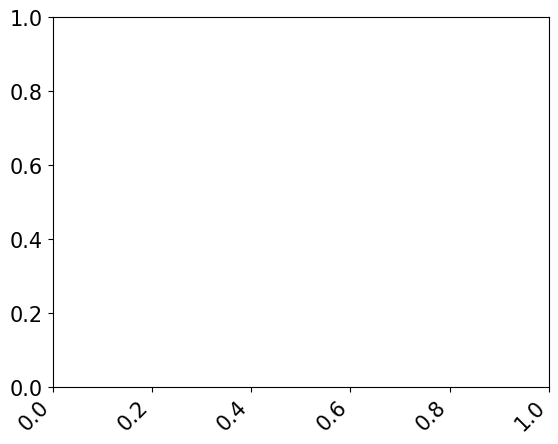

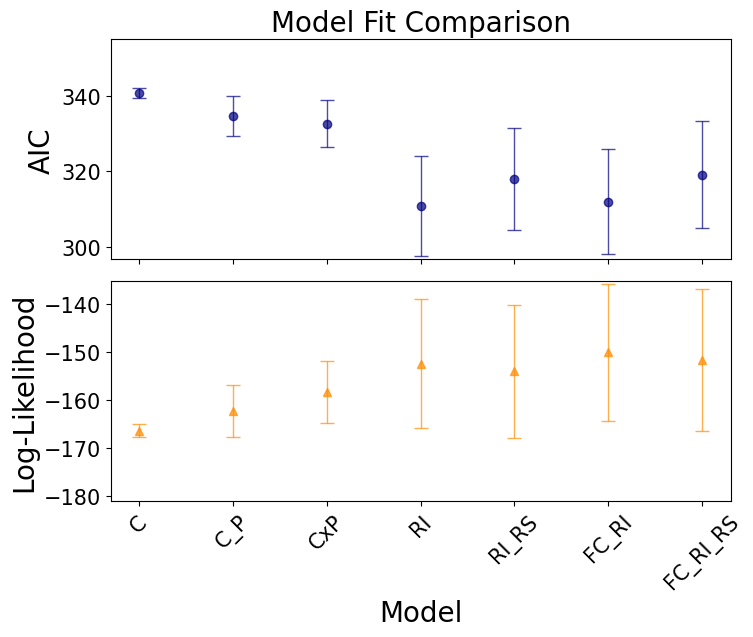

In [44]:
plot_model_comparison(df_combined)